# NYPD Crime Reports Dataset

This notebook analyzes the dataset with all the valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2022.

The dataset is available at:
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

It is a dataset with 8 million crimes reported to NYPD.

## Attribute Description


| Column | Description | Data Type
|--------|-------------------|----|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint  | bigint(20) |
| CMPLNT_FR | Exact datetime of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) | datetime |
| CMPLNT_TO | Ending datetime of occurrence for the reported event, if exact time of occurrence is unknown | datetime
| RPT_DT | Date event was reported to police  | date
| KY_CD | Three digit offense classification code | char(3)
| PD_CD | Three digit internal classification code (more granular than Key Code) | char(3)
| JURISDICTION_CODE	| | smallint(6)
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely | enum('COMPLETED','ATTEMPTED')
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation  | enum('FELONY','MISDEMEANOR','VIOLATION')
| BORO_NM | The name of the borough in which the incident occurred | enum('BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND')
| ADDR_PCT_CD | The precinct in which the incident occurred | char(3)
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of | enum('FRONT OF','INSIDE','OPPOSITE OF','OUTSIDE','REAR OF')
| PATROL_BORO | |	enum('PATROL BORO BRONX','PATROL BORO BKLYN SOUTH','PATROL BORO BKLYN NORTH','PATROL BORO MAN SOUTH','PATROL BORO MAN NORTH','PATROL BORO QUEENS NORTH','PATROL BORO QUEENS SOUTH','PATROL BORO STATEN ISLAND')
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. | varchar(80)
| SUSP_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| VIC_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| SUSP_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| VIC_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| SUSP_SEX  | |		enum('M','F')
| VIC_SEX  | |	enum('M','F','E','D')
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  | double
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) | double


### Auxiliary Tables

There are three auxiliary tables `jurisdiction_codes`, `offense_codes`, `penal_codes`, which provide descriptions for the `JURISDICTION_CODE`, `KY_CD`, and `PD_CD` attributes of the main table.




Additional Notes: https://www1.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/incident_level_data_footnotes.pdf



## MySQL Database

The dataset is hosted on a private MySQL server.
A public version is available on nyc.gov.

In [ ]:
# Installing packages
!sudo pip3 install  -U -q geopandas PyMySQL sqlalchemy sql_magic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00


In [ ]:
# Libraries

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import geopandas as gpd
import seaborn as sns
import matplotlib as plt

In [ ]:
# Access private server

conn_string = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    #user='UserID',
    #password='Password',
    #host = 'Host',
    port=3306
    db='nypd',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

# Analysis

This analysis, conducted using a combination of SQL and Python, addresses five key questions:

### 1. Composition of crimes

* The total number of reported crimes in the dataset.
* Breakdown reported crimes among felony, misdemeanor, and violation.
* The top-10 most reported crimes among felonies.

### 2. Temporal trends in crime

* Total number of all reported crimes per year
* Total number of all reported crimes per month

### 3. Focus on major felonies

* Reporting the number of these crimes over time by felony type

### 4. Major felonies by hour of day

- Breakdown of major felonies by hour of the day
- Normalized hourly trend of major felonies for easier comparison

### 5. Spatial analysis

* Where in New York City are these crimes taking place?
* A density map is used to visualize the geographic concentration of each major felony.


#1. Composition of crimes

In [ ]:
# The total number of reported crimes in the dataset?

sql = '''
SELECT COUNT(*) as Total_Crimes
FROM nypd
'''
with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,Total_Crimes
0,8338675


In [ ]:
# Analyzing the column LAW_CAT_CD and report the number of felonies, misdemeanors, and violations.

sql = '''
SELECT LAW_CAT_CD, COUNT(*) as Count
FROM nypd
GROUP BY LAW_CAT_CD
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,LAW_CAT_CD,Count
0,FELONY,2596201
1,MISDEMEANOR,4625621
2,VIOLATION,1116853


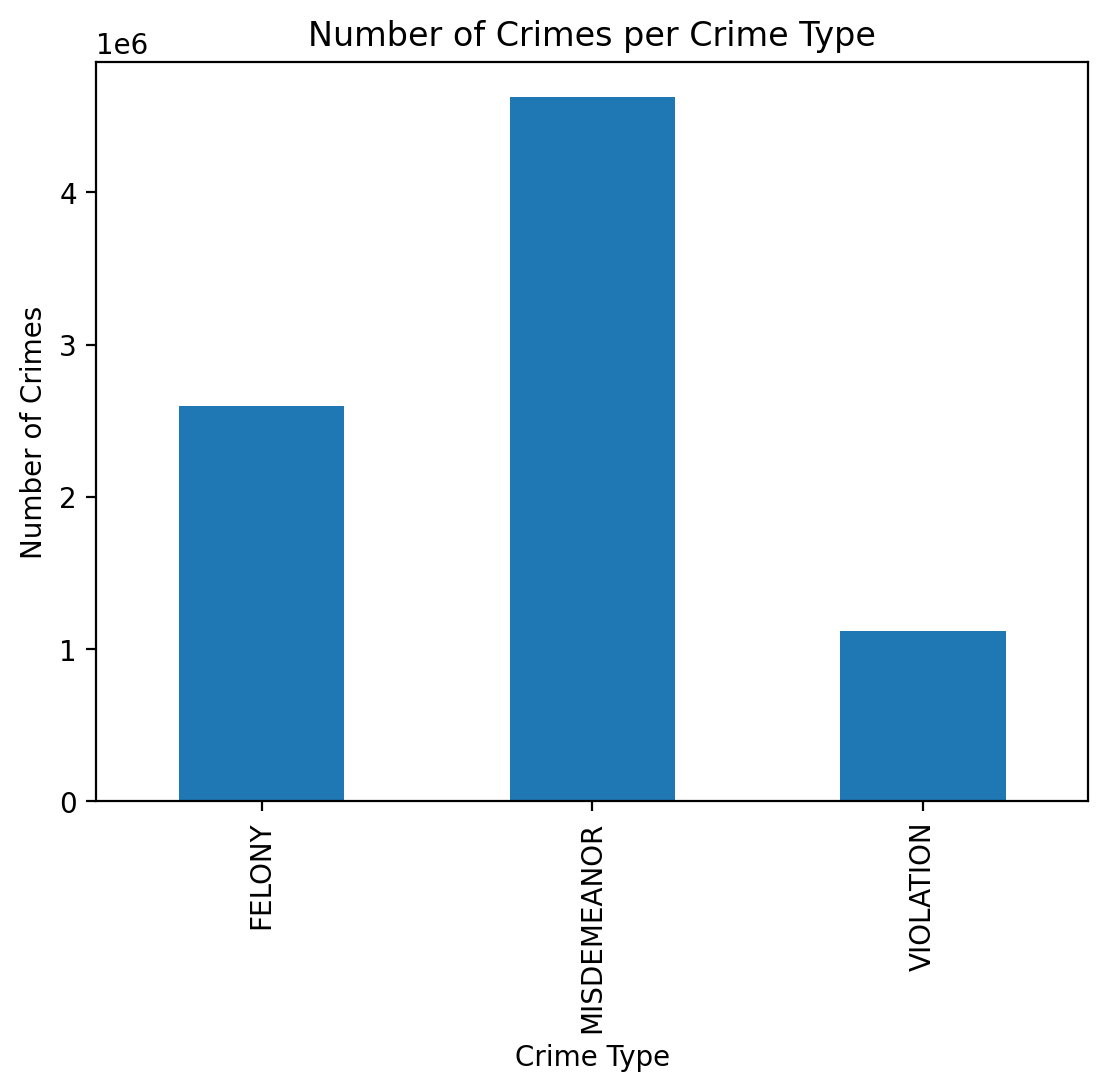

In [ ]:
# Creating a bar plot showing the values across the three crime types.

df.plot(kind='bar', x='LAW_CAT_CD', y='Count', legend=False, title='Number of Crimes per Crime Type')
plt.pyplot.xlabel('Crime Type')
plt.pyplot.ylabel('Number of Crimes')
plt.pyplot.show()


In [ ]:
# Breaking down felony crimes by offense type

sql = '''
SELECT offense_codes.OFNS_DESC, COUNT(*) as Count
FROM nypd
JOIN offense_codes ON nypd.KY_CD = offense_codes.KY_CD
WHERE nypd.LAW_CAT_CD = 'FELONY'
GROUP BY offense_codes.OFNS_DESC
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,OFNS_DESC,Count
0,GRAND LARCENY OF MOTOR VEHICLE,157669
1,ROBBERY,297097
2,GRAND LARCENY,729798
3,FORGERY,82728
4,FELONY ASSAULT,334184
5,MISCELLANEOUS PENAL LAW,203660
6,BURGLARY,282233
7,THEFT-FRAUD,83698
8,DANGEROUS DRUGS,92797
9,CRIMINAL MISCHIEF & RELATED OF,151450


In [ ]:
# Creating a bar plot showing the frequency of the top-10 offense descriptions

sql = '''
SELECT offense_codes.OFNS_DESC, COUNT(*) as Frequency
FROM nypd
JOIN offense_codes ON nypd.KY_CD = offense_codes.KY_CD
GROUP BY offense_codes.OFNS_DESC
ORDER BY Frequency DESC
LIMIT 10
'''

with engine.connect() as connection:
    df = pd.read_sql(text(sql), con=connection)


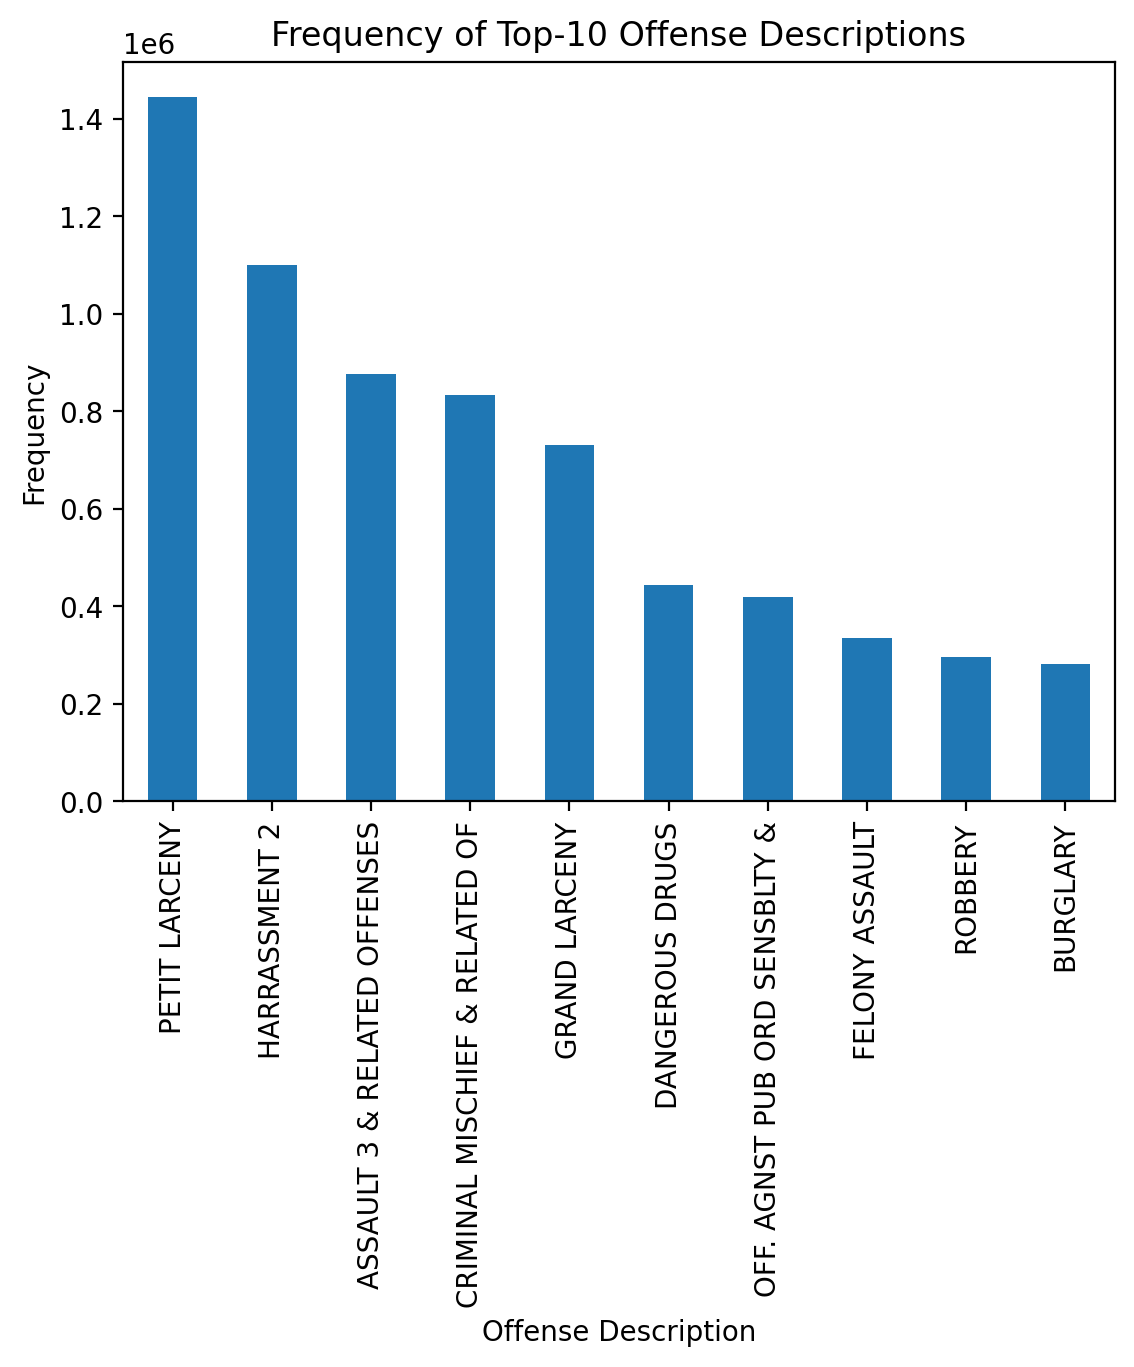

In [ ]:
df.plot(kind='bar', x='OFNS_DESC', y='Frequency', legend=False, title='Frequency of Top-10 Offense Descriptions')
plt.pyplot.xlabel('Offense Description')
plt.pyplot.ylabel('Frequency')
plt.pyplot.show()


## 2. Temporal trends in crime

* Total number of all reported crimes per year
* Total number of all reported crimes per month


In [ ]:
# Creating a plot that shows the total number of all reported crimes per year.
sql = '''
SELECT YEAR(CMPLNT_FR) AS Year, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2022-12-31'
GROUP BY Year
ORDER BY Year
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,Year,Crime_Count
0,2006,528805
1,2007,535152
2,2008,528603
3,2009,510872
4,2010,510028
5,2011,498557
6,2012,504699
7,2013,495129
8,2014,491186
9,2015,477801


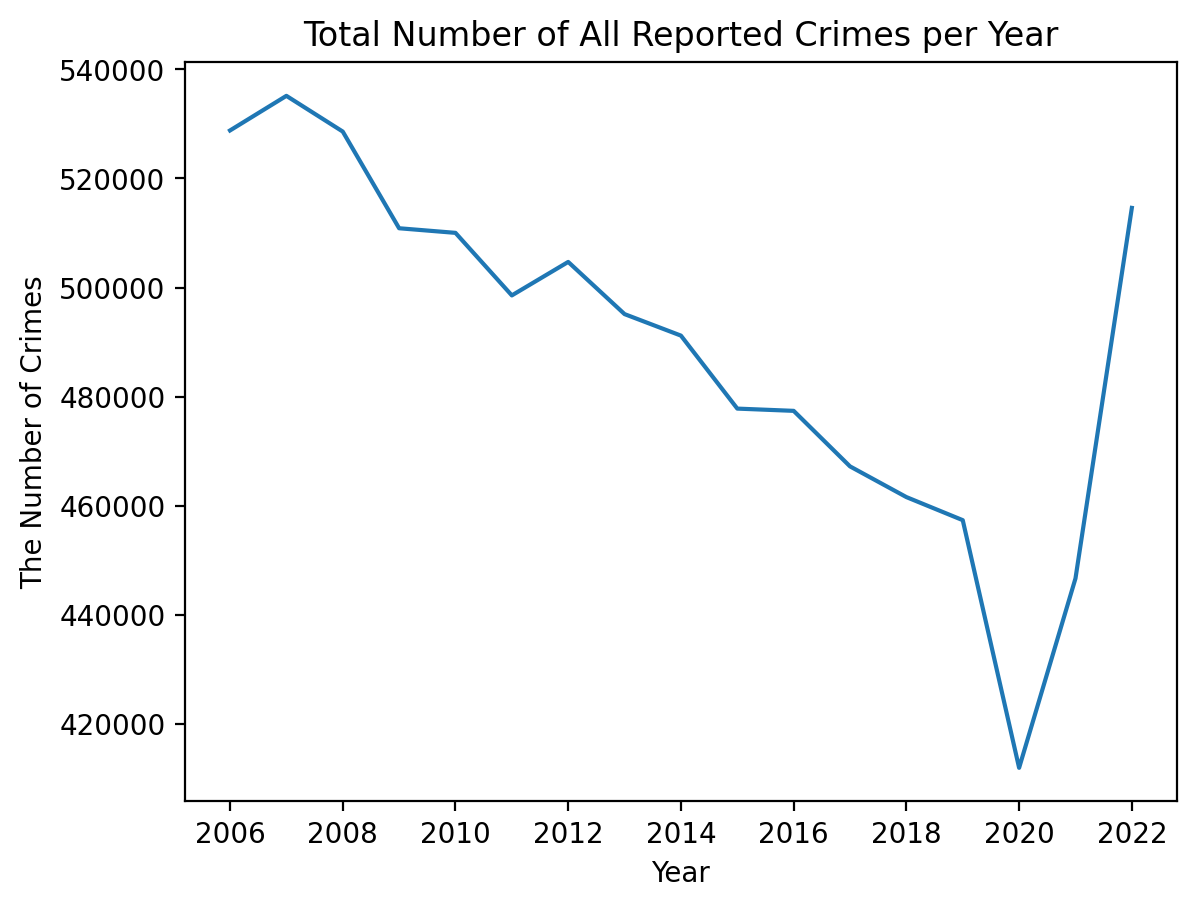

In [ ]:
df.plot(kind='line', x='Year', y='Crime_Count', legend=False, title='Total Number of All Reported Crimes per Year')
plt.pyplot.xlabel('Year')
plt.pyplot.ylabel('The Number of Crimes')
plt.pyplot.show()


In [ ]:
# Creating a plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, Dec-2022).

sql = '''
SELECT DATE_FORMAT(CMPLNT_FR, '%Y-%m') AS Month, COUNT(*) AS Crime_Count
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2022-12-31'
GROUP BY Month
ORDER BY Month
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df



,Month,Crime_Count
0,2006-01,43970
1,2006-02,36941
2,2006-03,43677
3,2006-04,42181
4,2006-05,45350
...,...,...
199,2022-08,46050
200,2022-09,44407
201,2022-10,45330
202,2022-11,42759


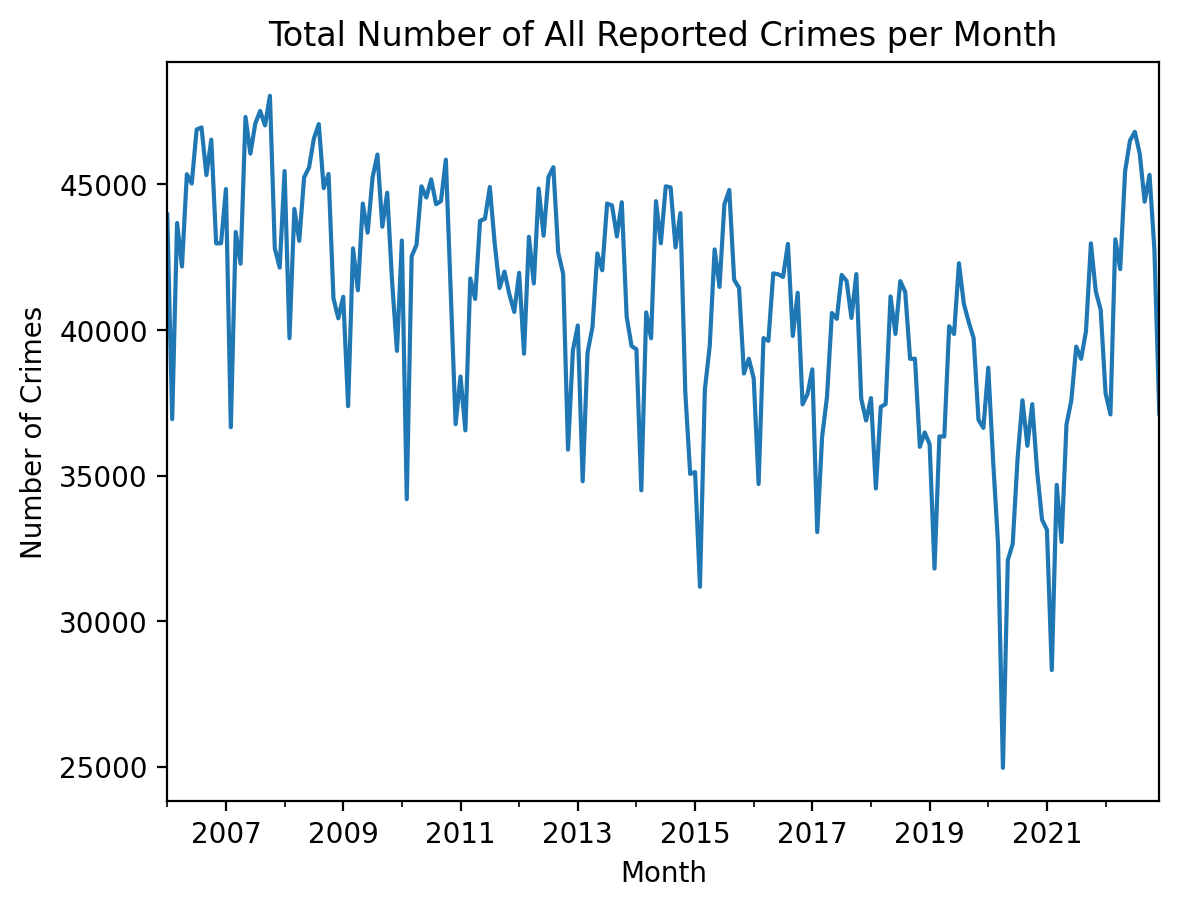

In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
df.plot(kind='line', x='Month', y='Crime_Count', legend=False, title='Total Number of All Reported Crimes per Month')
plt.pyplot.xlabel('Month')
plt.pyplot.ylabel('Number of Crimes')
plt.pyplot.show()

## 3. Focus on major felonies

The major felonies are;
* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE
* RAPE
* MURDER & NON-NEGL. MANSLAUGHTER

Reporting the number of these crimes over time by felony type.


In [ ]:
sql = '''
SELECT DATE_FORMAT(CMPLNT_FR, '%Y-%m') as Month, OC.OFNS_DESC, COUNT(*) as Crime_Count
FROM nypd AS main
JOIN offense_codes AS OC ON main.KY_CD = OC.KY_CD
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2022-12-31'
AND OC.OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY',
'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE', 'MURDER & NON-NEGL. MANSLAUGHTER')
GROUP BY Month, OC.OFNS_DESC
ORDER BY Month
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)



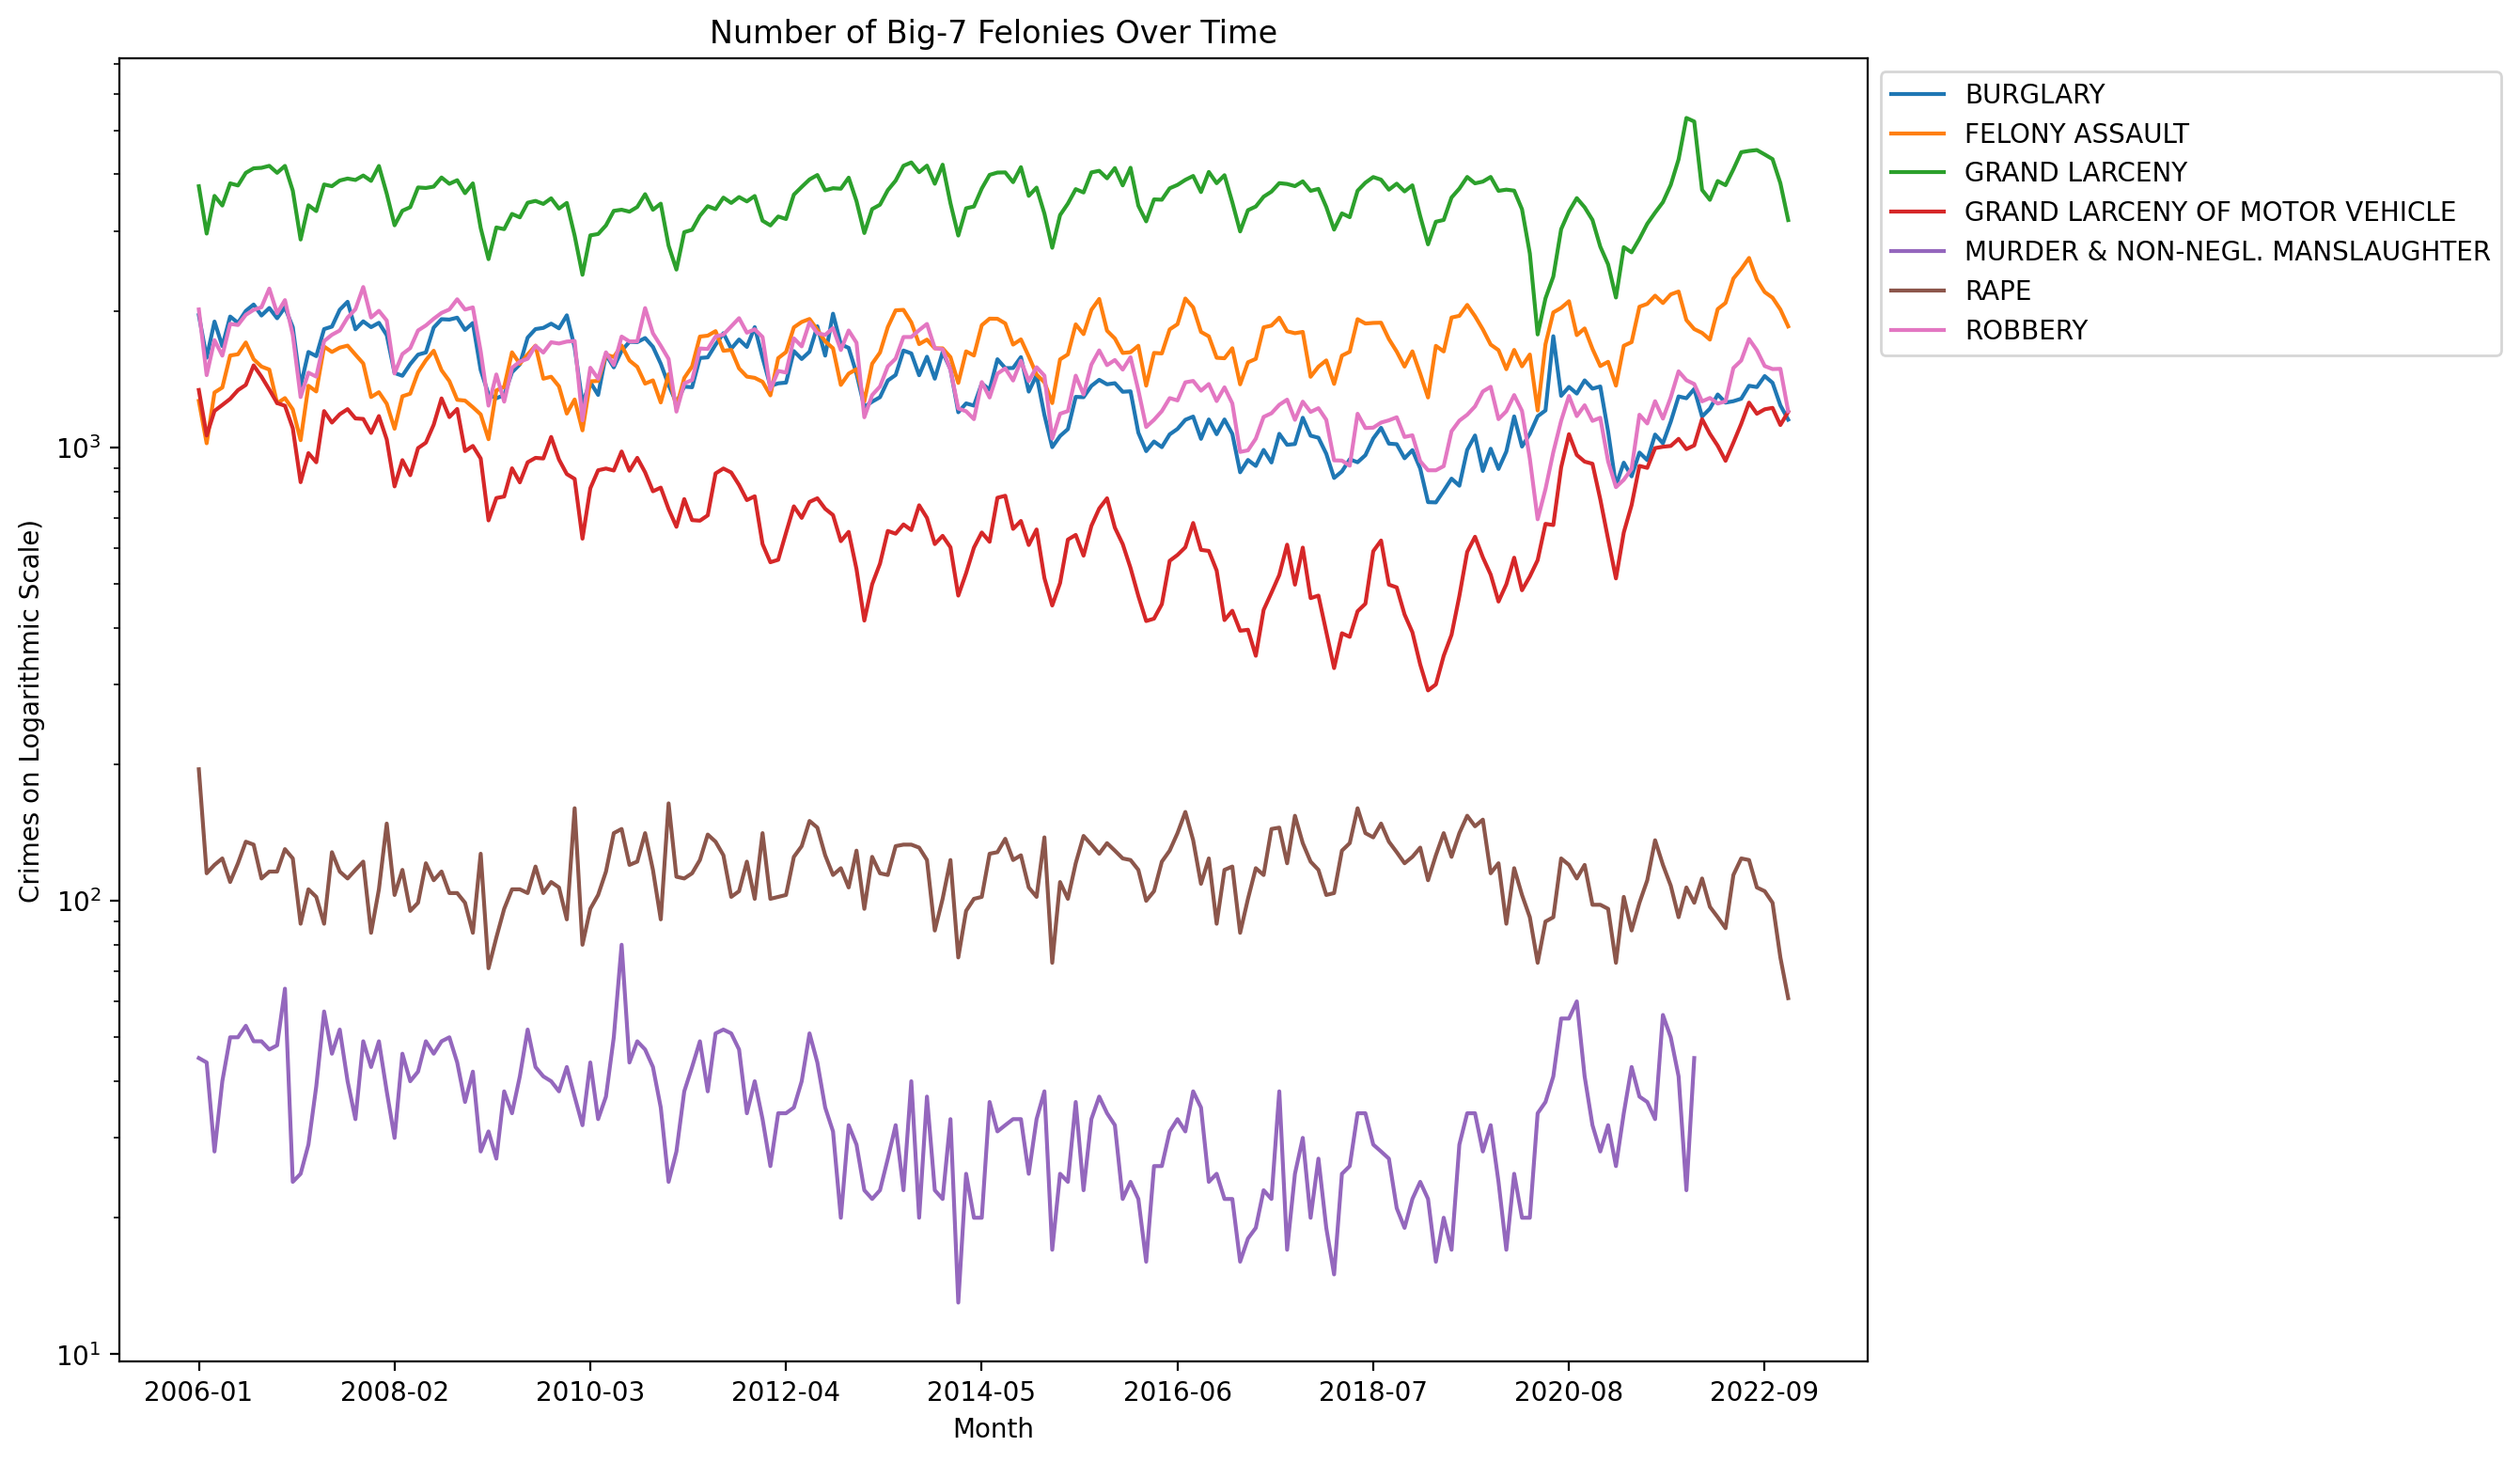

In [ ]:

df_pivot = df.pivot(index='Month', columns='OFNS_DESC', values='Crime_Count')

ax = df_pivot.plot(logy=True, title='Number of Big-7 Felonies Over Time', figsize=(12,9))
ax.legend(bbox_to_anchor=(1, 1))
plt.pyplot.xlabel('Month')
plt.pyplot.ylabel('Crimes on Logarithmic Scale)')
plt.pyplot.show()


## 4. Major felonies by hour of the day

- Breakdown of major felonies by hour of the day
- Normalized hourly trend of major felonies for easier comparison


In [ ]:
sql = '''
SELECT HOUR(CMPLNT_FR) AS Hour, OC.OFNS_DESC, COUNT(*) as Crime_Count
FROM nypd AS main
JOIN offense_codes AS OC ON main.KY_CD = OC.KY_CD
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2022-12-31'
AND OC.OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY',
'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE', 'MURDER & NON-NEGL. MANSLAUGHTER')
GROUP BY Hour, OC.OFNS_DESC
ORDER BY Hour
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,Hour,OFNS_DESC,Crime_Count
0,0,BURGLARY,9581
1,0,FELONY ASSAULT,18449
2,0,GRAND LARCENY,40967
3,0,GRAND LARCENY OF MOTOR VEHICLE,6930
4,0,MURDER & NON-NEGL. MANSLAUGHTER,429
...,...,...,...
163,23,GRAND LARCENY,23080
164,23,GRAND LARCENY OF MOTOR VEHICLE,11160
165,23,MURDER & NON-NEGL. MANSLAUGHTER,427
166,23,RAPE,1366


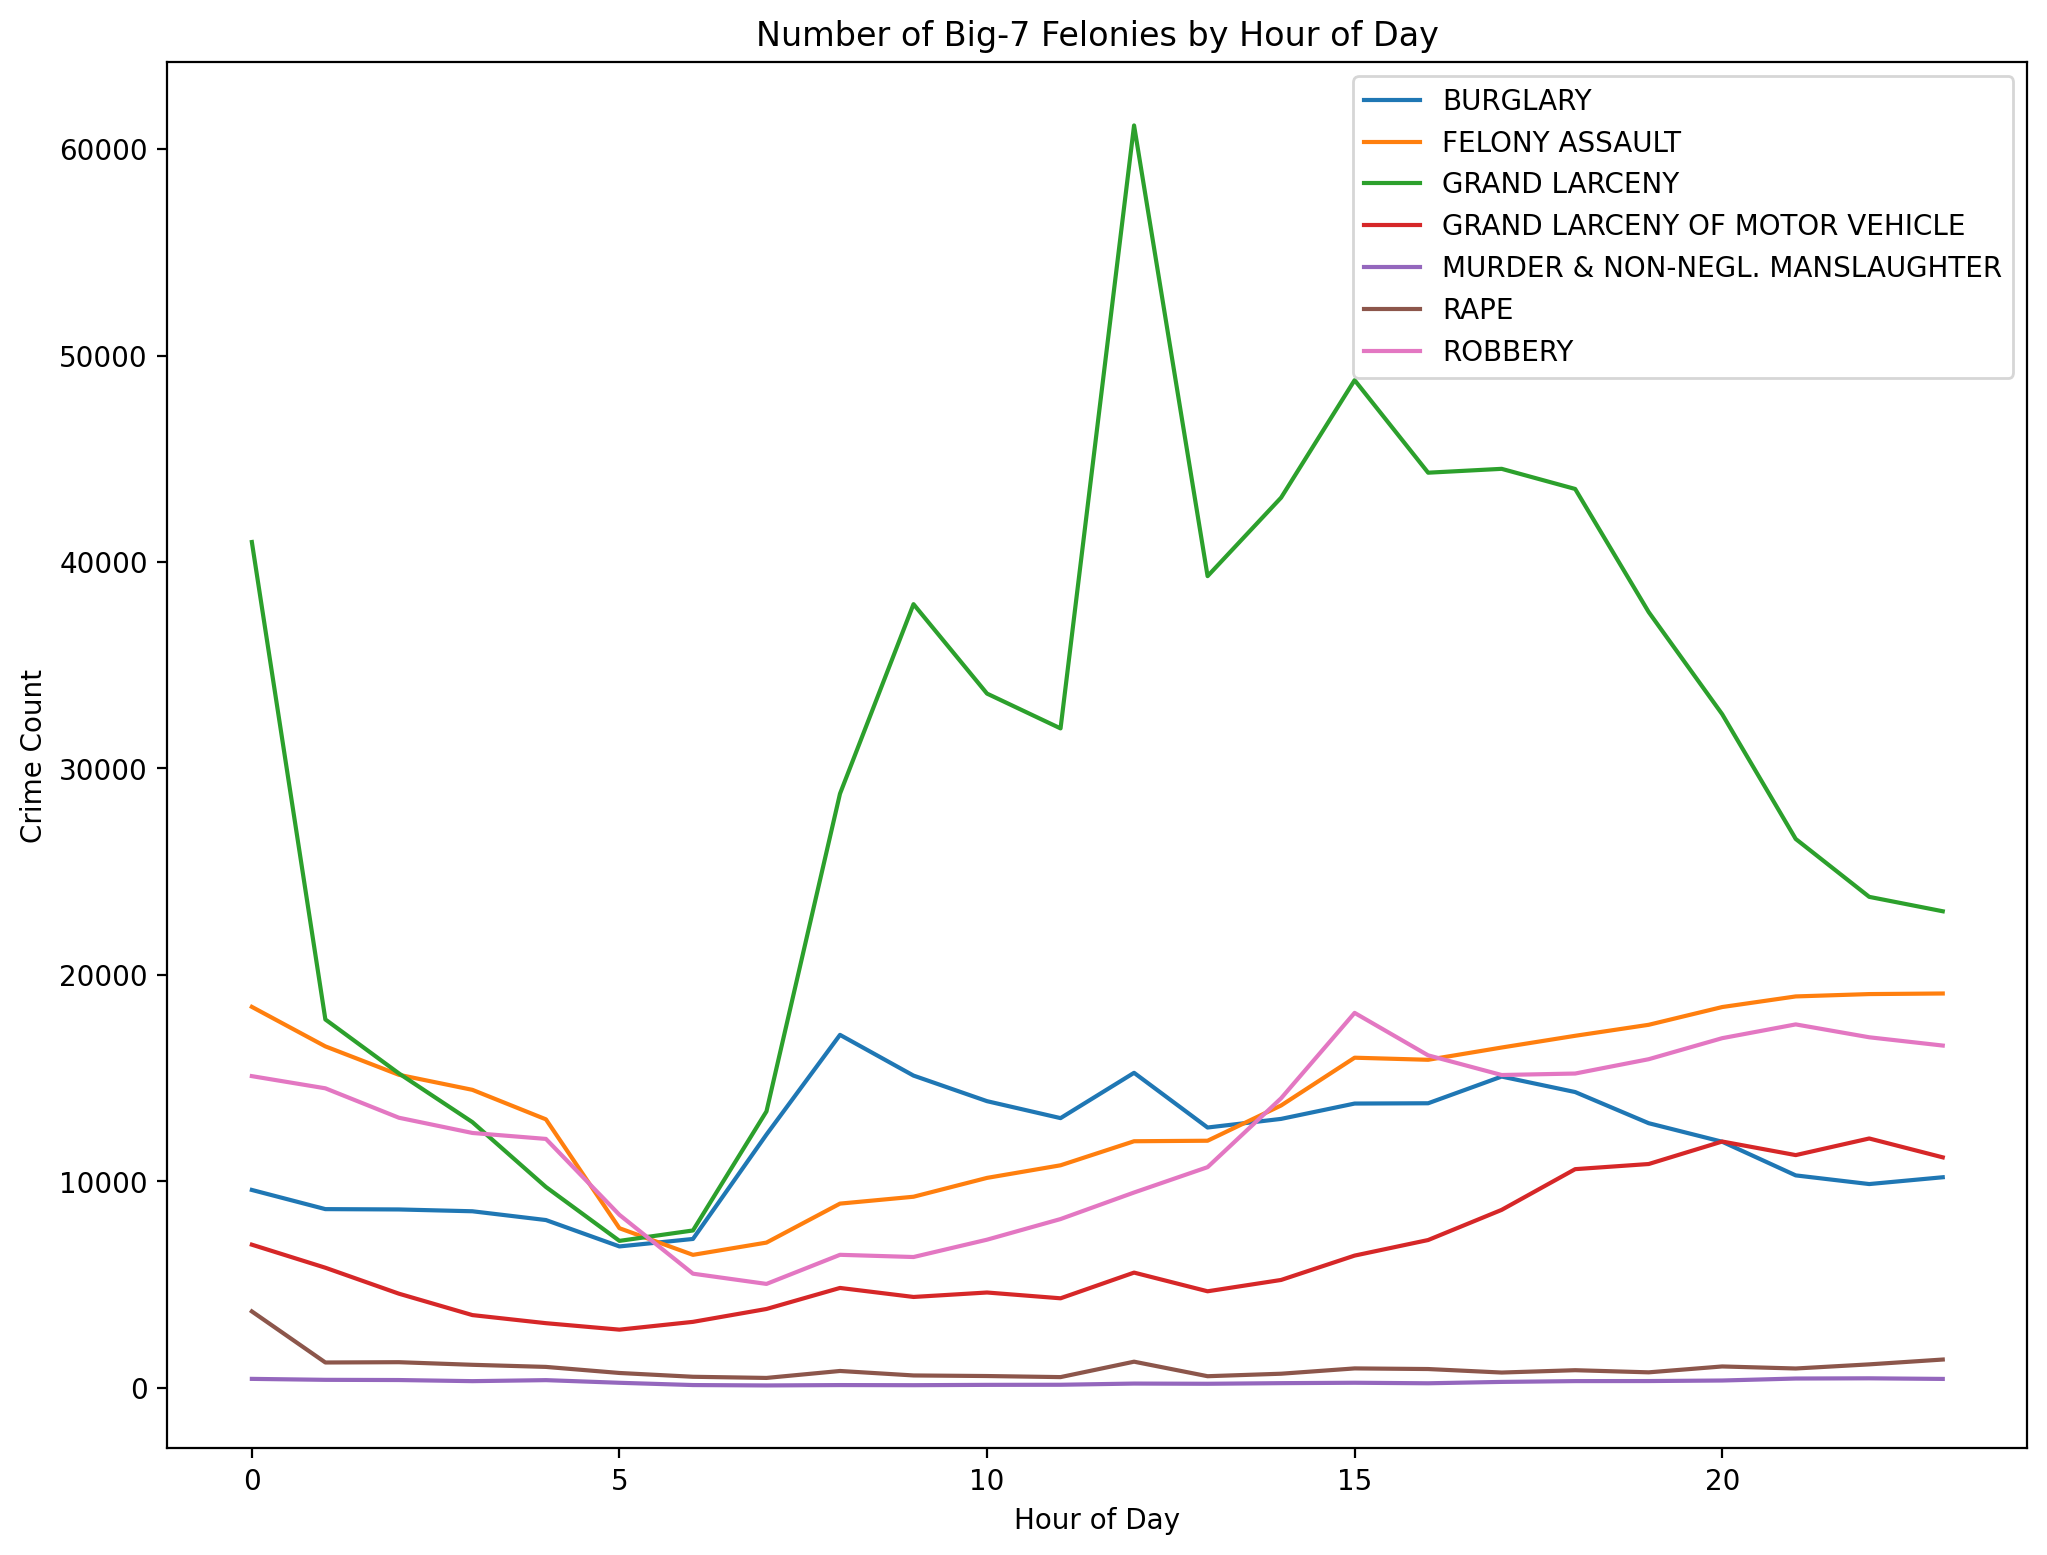

In [ ]:
# Generating a plot showing the number of major felonies by hour of day
df_pivot = df.pivot(index='Hour', columns='OFNS_DESC', values='Crime_Count')

ax = df_pivot.plot(title='Number of Big-7 Felonies by Hour of Day', figsize=(12,9))
ax.legend(bbox_to_anchor=(1, 1))
plt.pyplot.xlabel('Hour of Day')
plt.pyplot.ylabel('Crime Count')
plt.pyplot.show()

<ipython-input-26-44a34f27cd7a>:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Normalized_Crimes'] = df.groupby('OFNS_DESC')['Crime_Count'].apply(lambda x: x / x.sum())


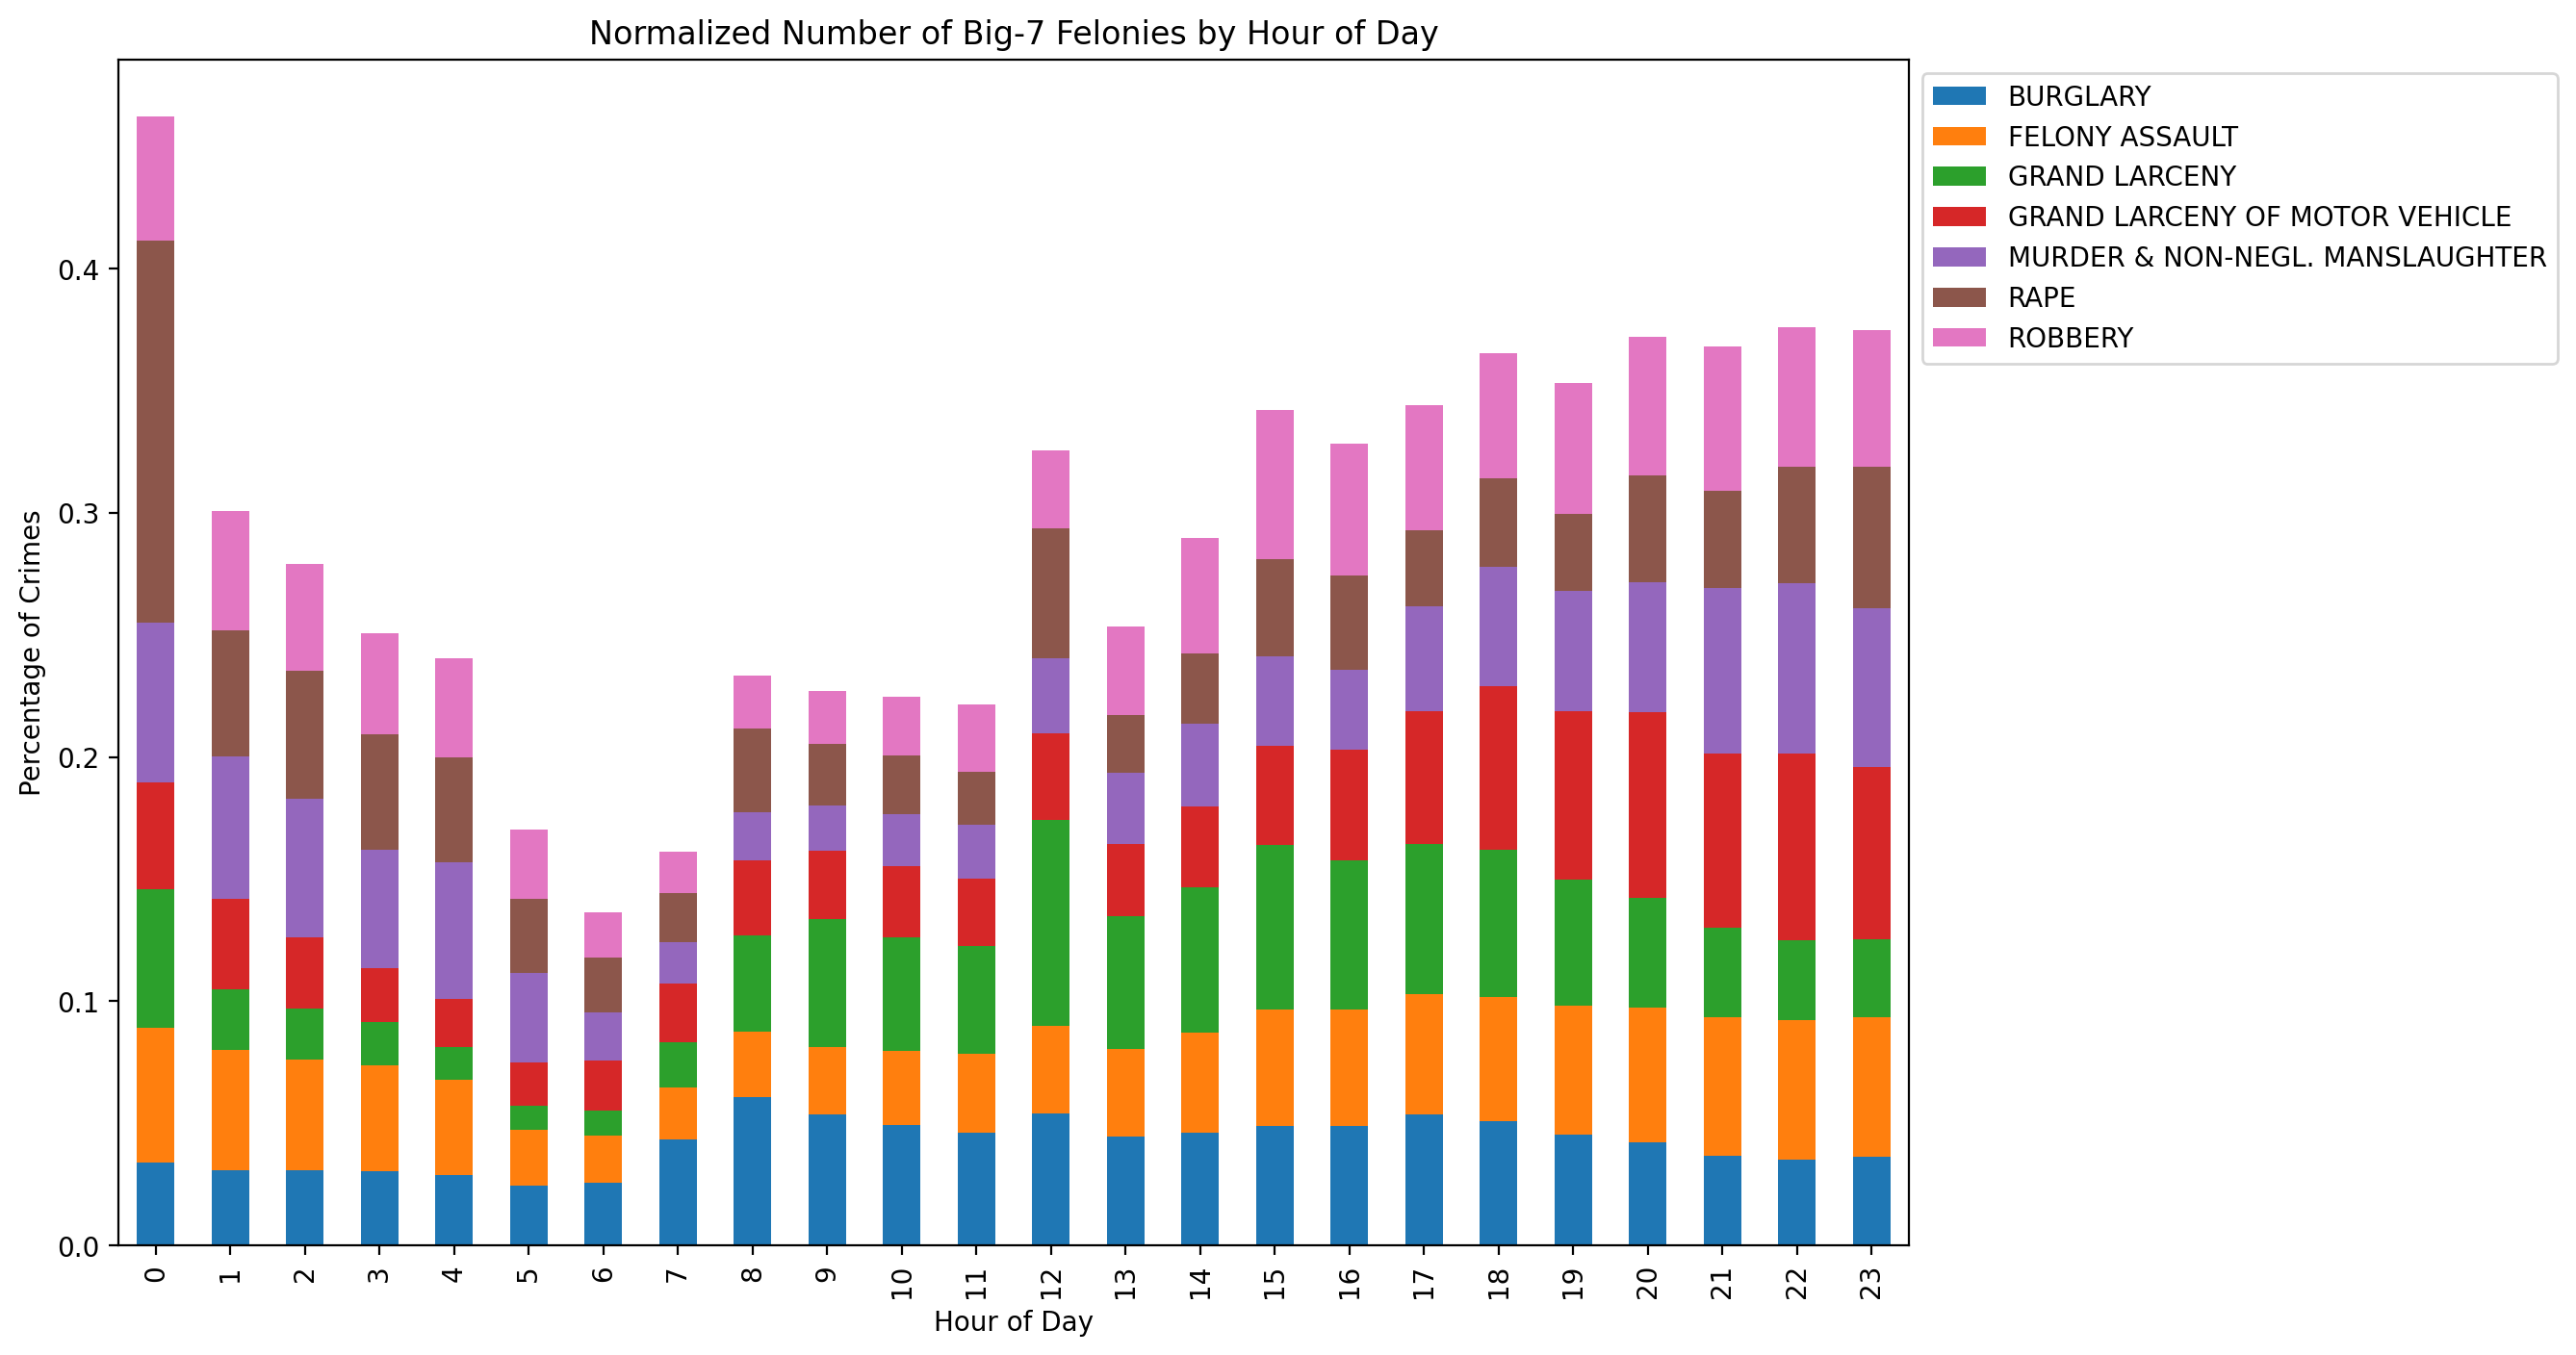

In [ ]:
# Normalizing the data
df['Normalized_Crimes'] = df.groupby('OFNS_DESC')['Crime_Count'].apply(lambda x: x / x.sum())

# Pivoting the data
df_pivot_normalized = df.pivot(index='Hour', columns='OFNS_DESC', values='Normalized_Crimes')

# Generating a bar plot
ax = df_pivot_normalized.plot(kind='bar', stacked=True, title='Normalized Number of Big-7 Felonies by Hour of Day', figsize=(12,8))
ax.legend(bbox_to_anchor=(1, 1))
plt.pyplot.xlabel('Hour of Day')
plt.pyplot.ylabel('Percentage of Crimes')
plt.pyplot.show()


## 5. Spatial Analysis

Analyzing the spatial density for the following types of felonies:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE

In [ ]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4370k    0 4370k    0     0  1756k      0 --:--:--  0:00:02 --:--:-- 1755k


<Axes: >

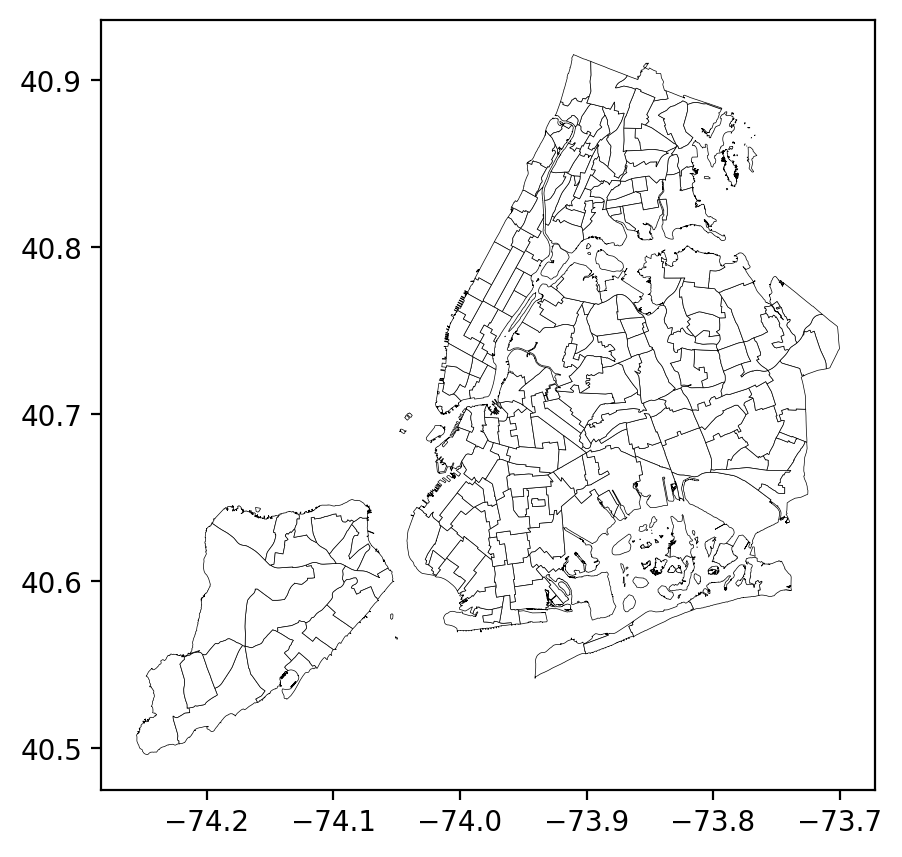

In [ ]:
# Load the shapefile
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')

# Create a plot
df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

In [ ]:
sql = '''
SELECT Latitude, Longitude, offense_codes.OFNS_DESC
FROM nypd
JOIN offense_codes ON nypd.KY_CD = offense_codes.KY_CD
WHERE offense_codes.OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE') AND YEAR(CMPLNT_FR) = 2022 AND Latitude IS NOT NULL AND Longitude IS NOT NULL

'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,Latitude,Longitude,OFNS_DESC
0,40.749405,-73.991783,FELONY ASSAULT
1,40.697994,-73.797859,FELONY ASSAULT
2,40.701313,-73.981796,FELONY ASSAULT
3,40.701790,-73.808403,FELONY ASSAULT
4,40.744446,-73.773697,FELONY ASSAULT
...,...,...,...
119855,40.762264,-73.958565,GRAND LARCENY
119856,40.848667,-73.937370,GRAND LARCENY
119857,40.805737,-73.940643,ROBBERY
119858,40.683292,-73.974854,GRAND LARCENY


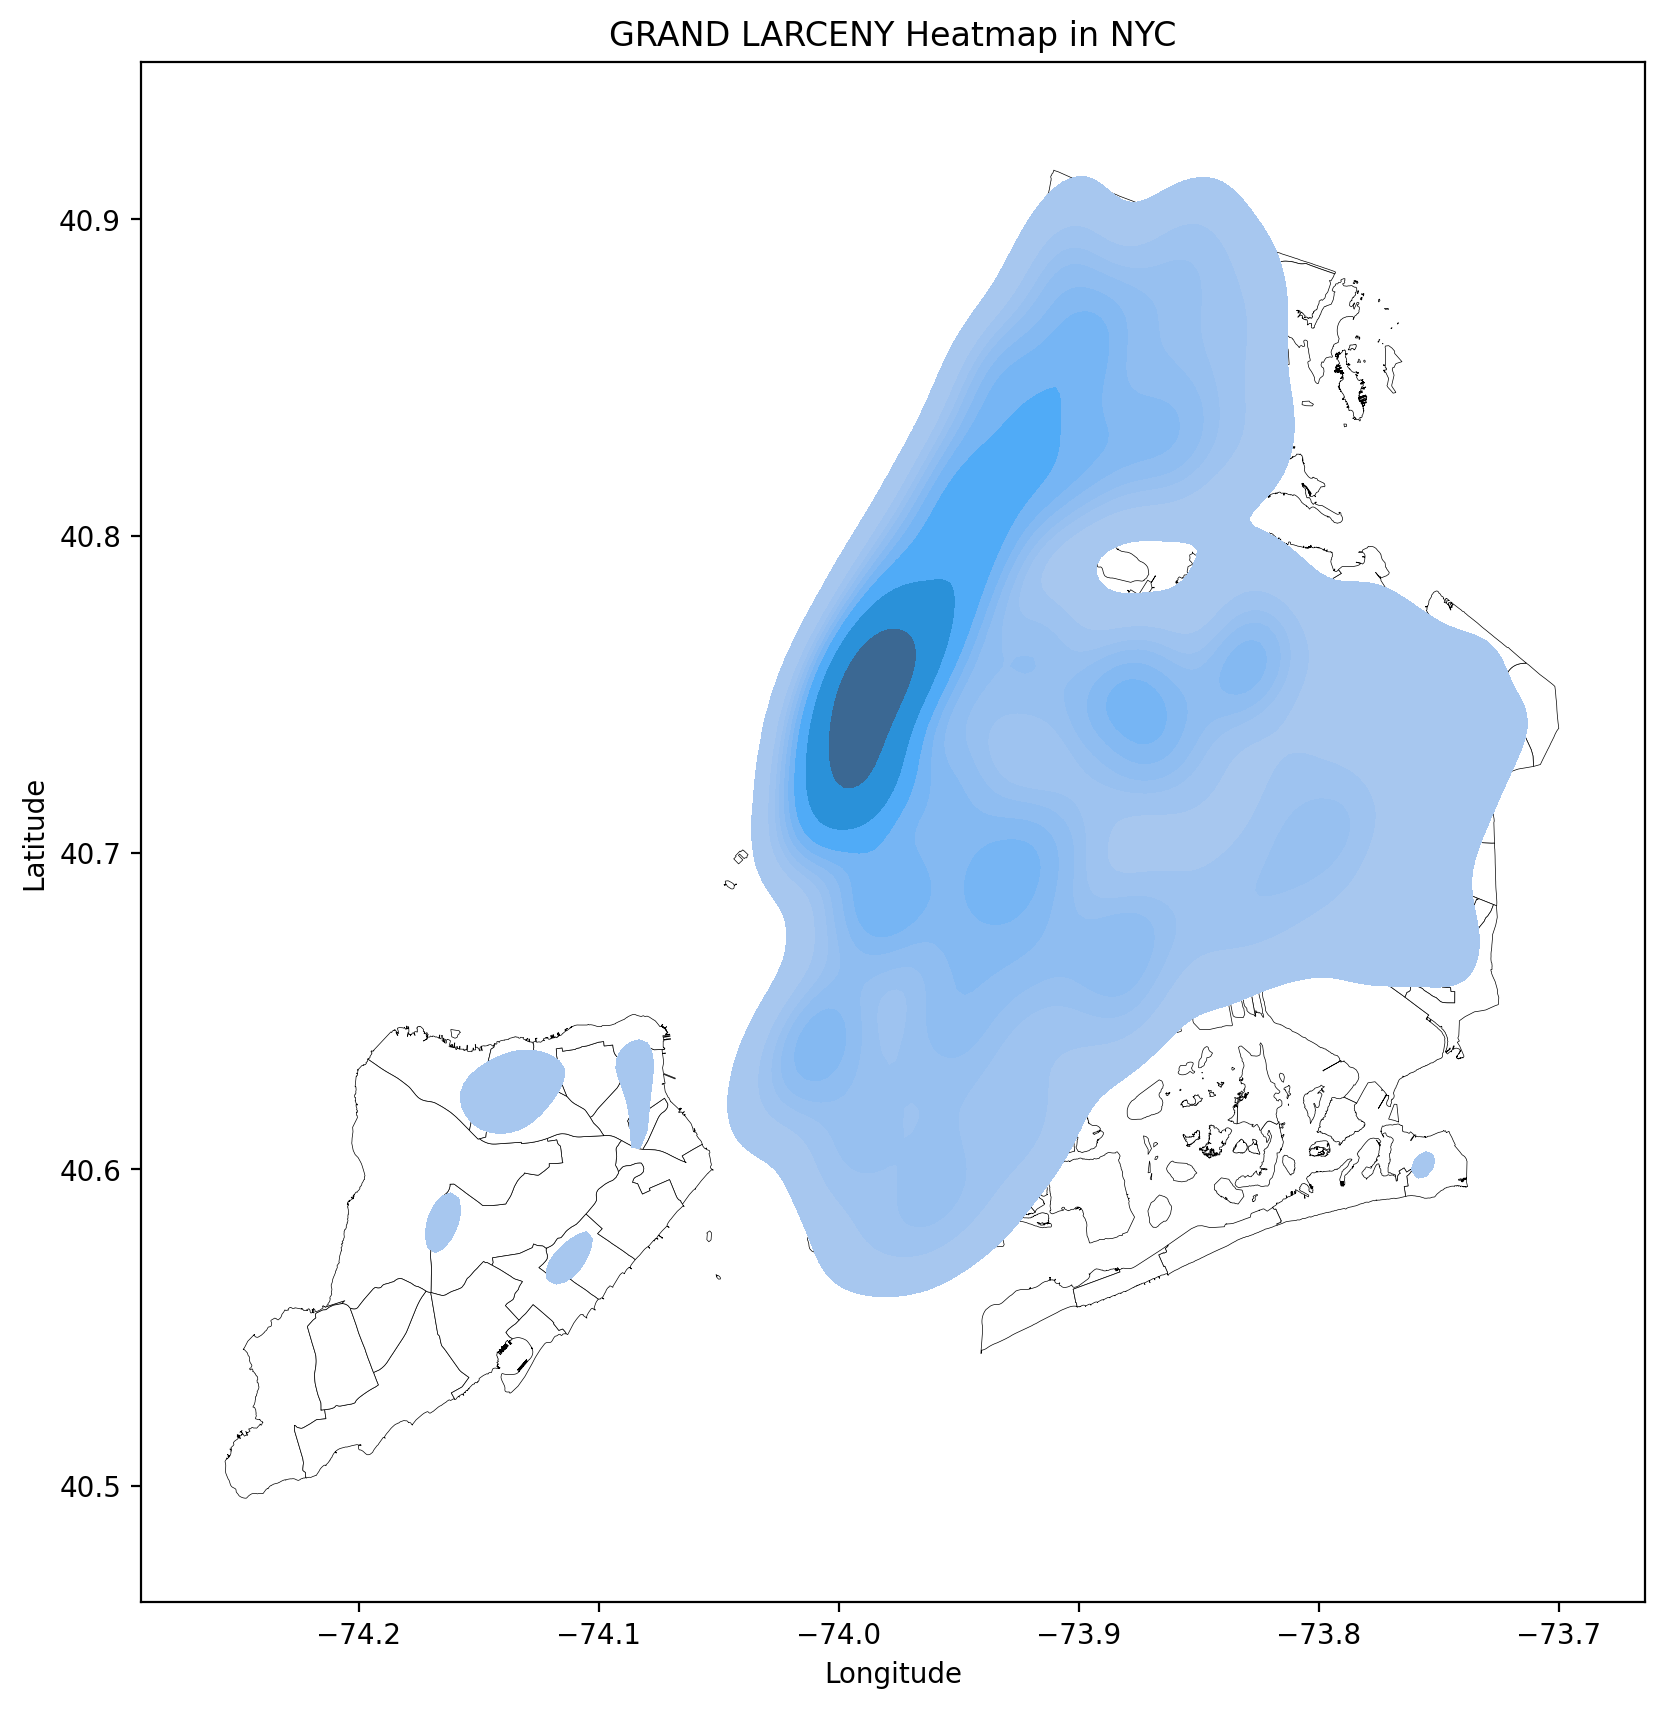

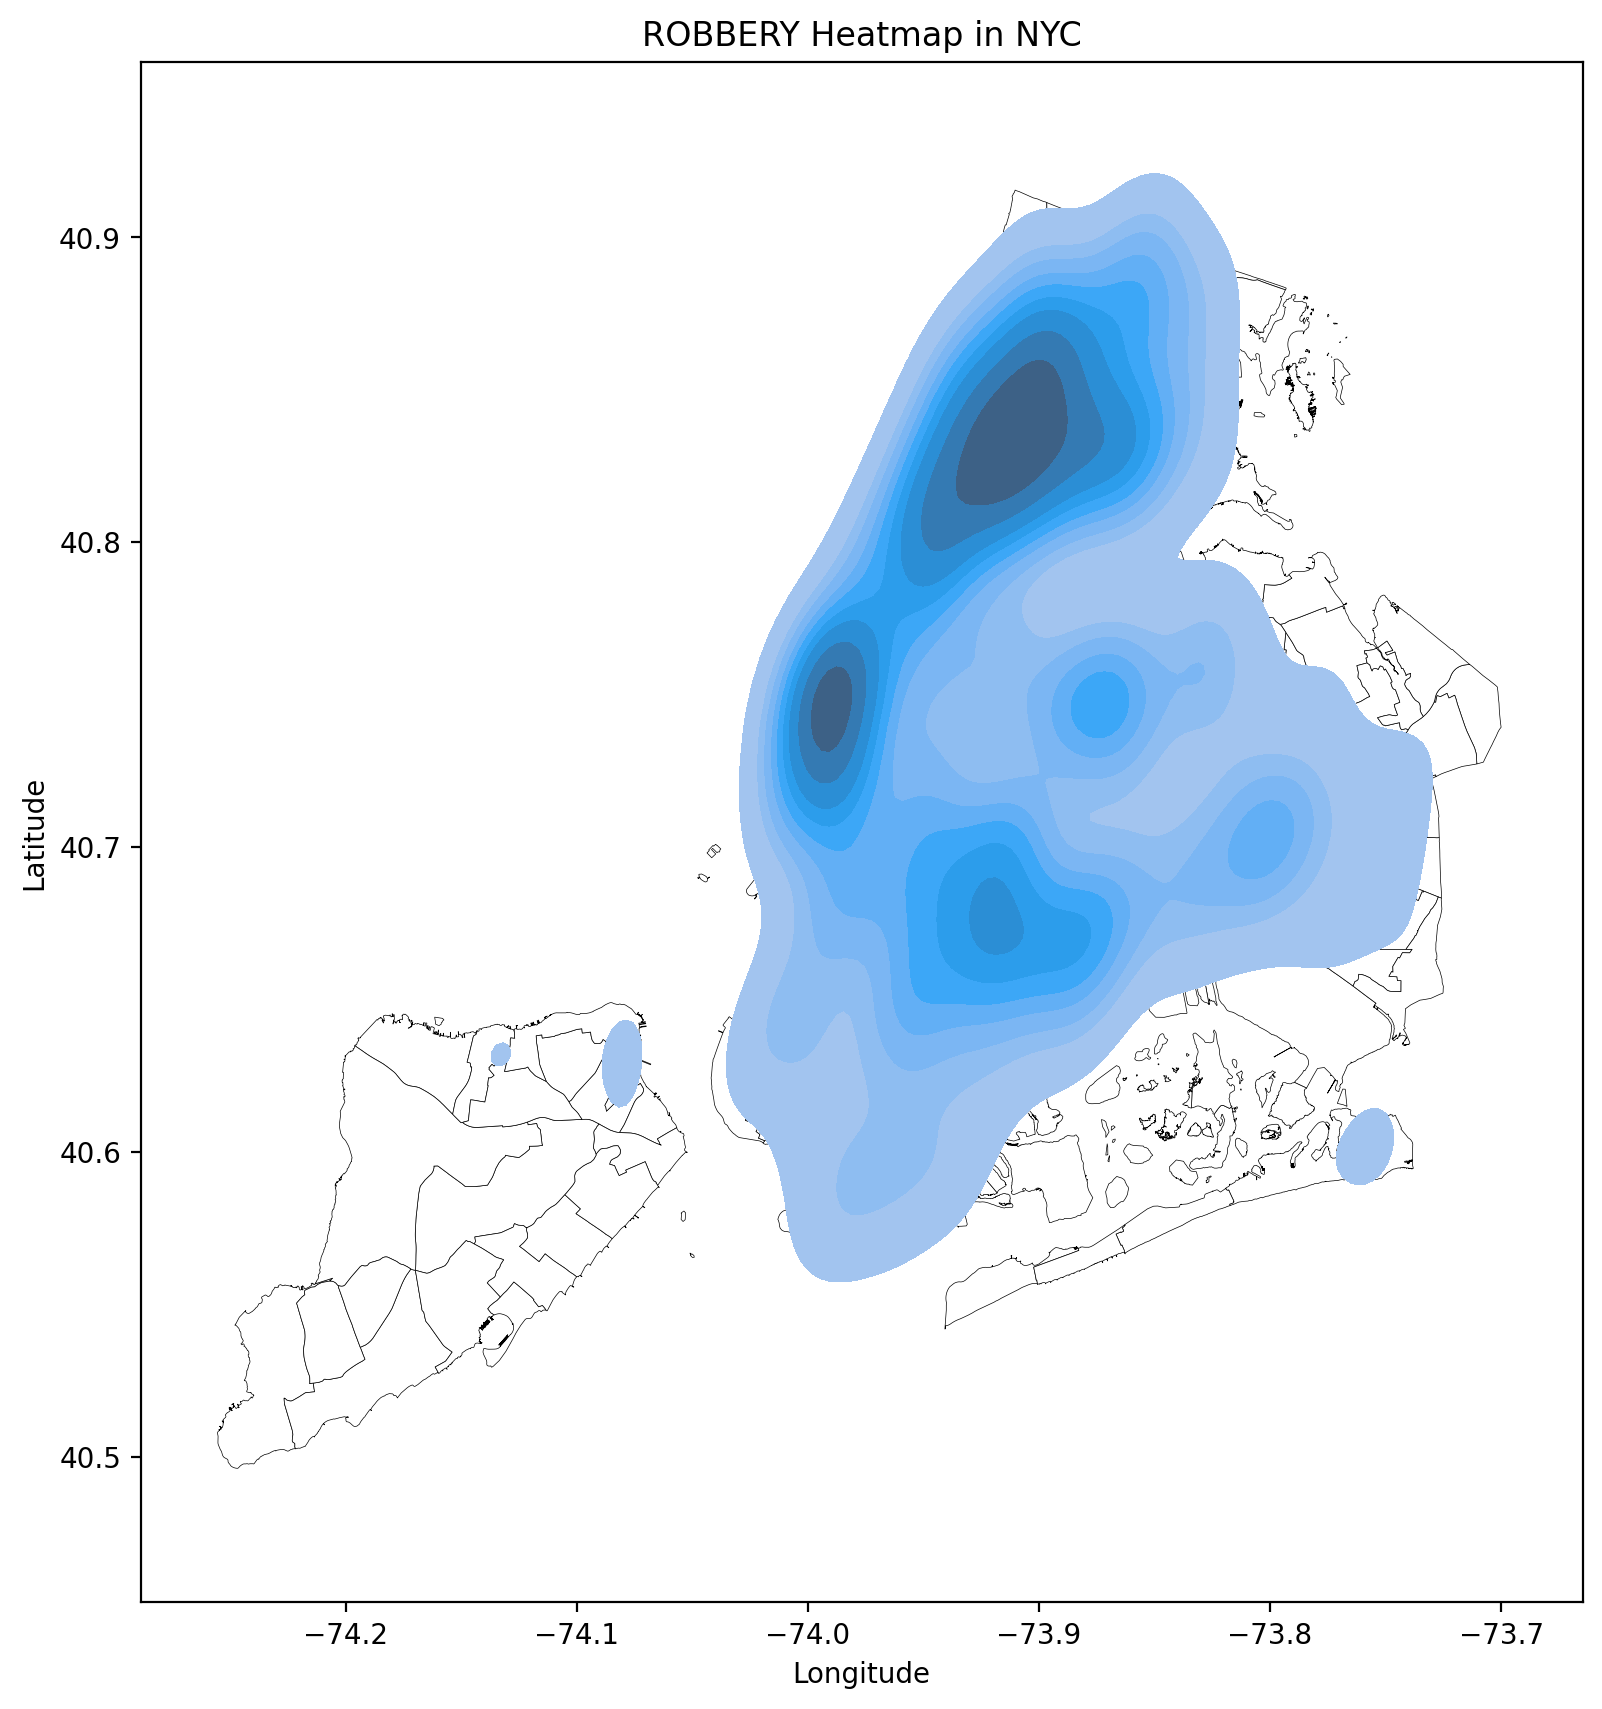

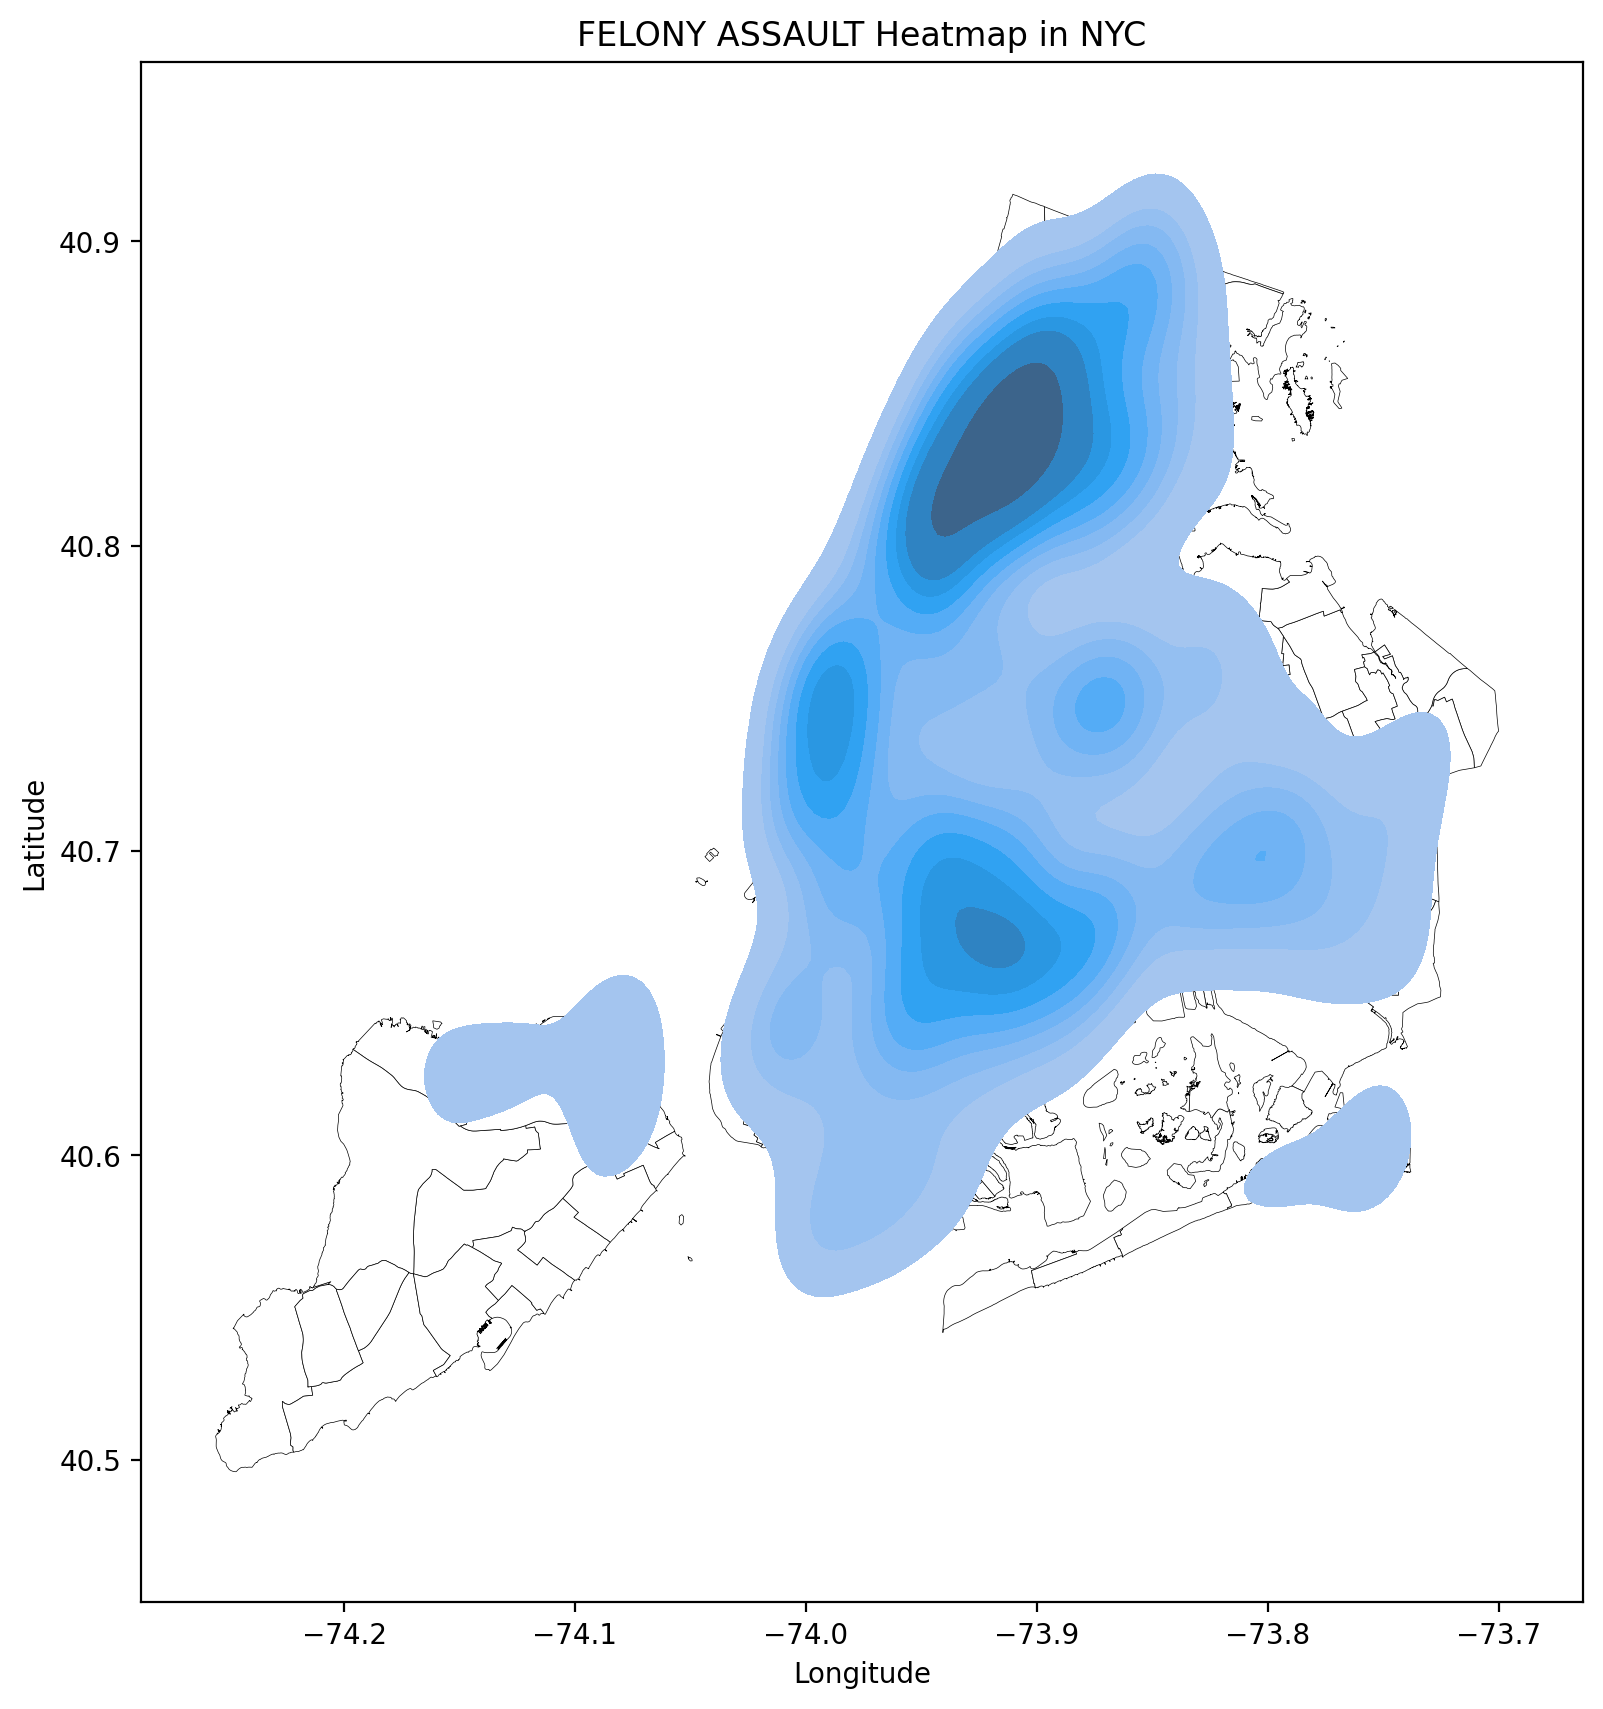

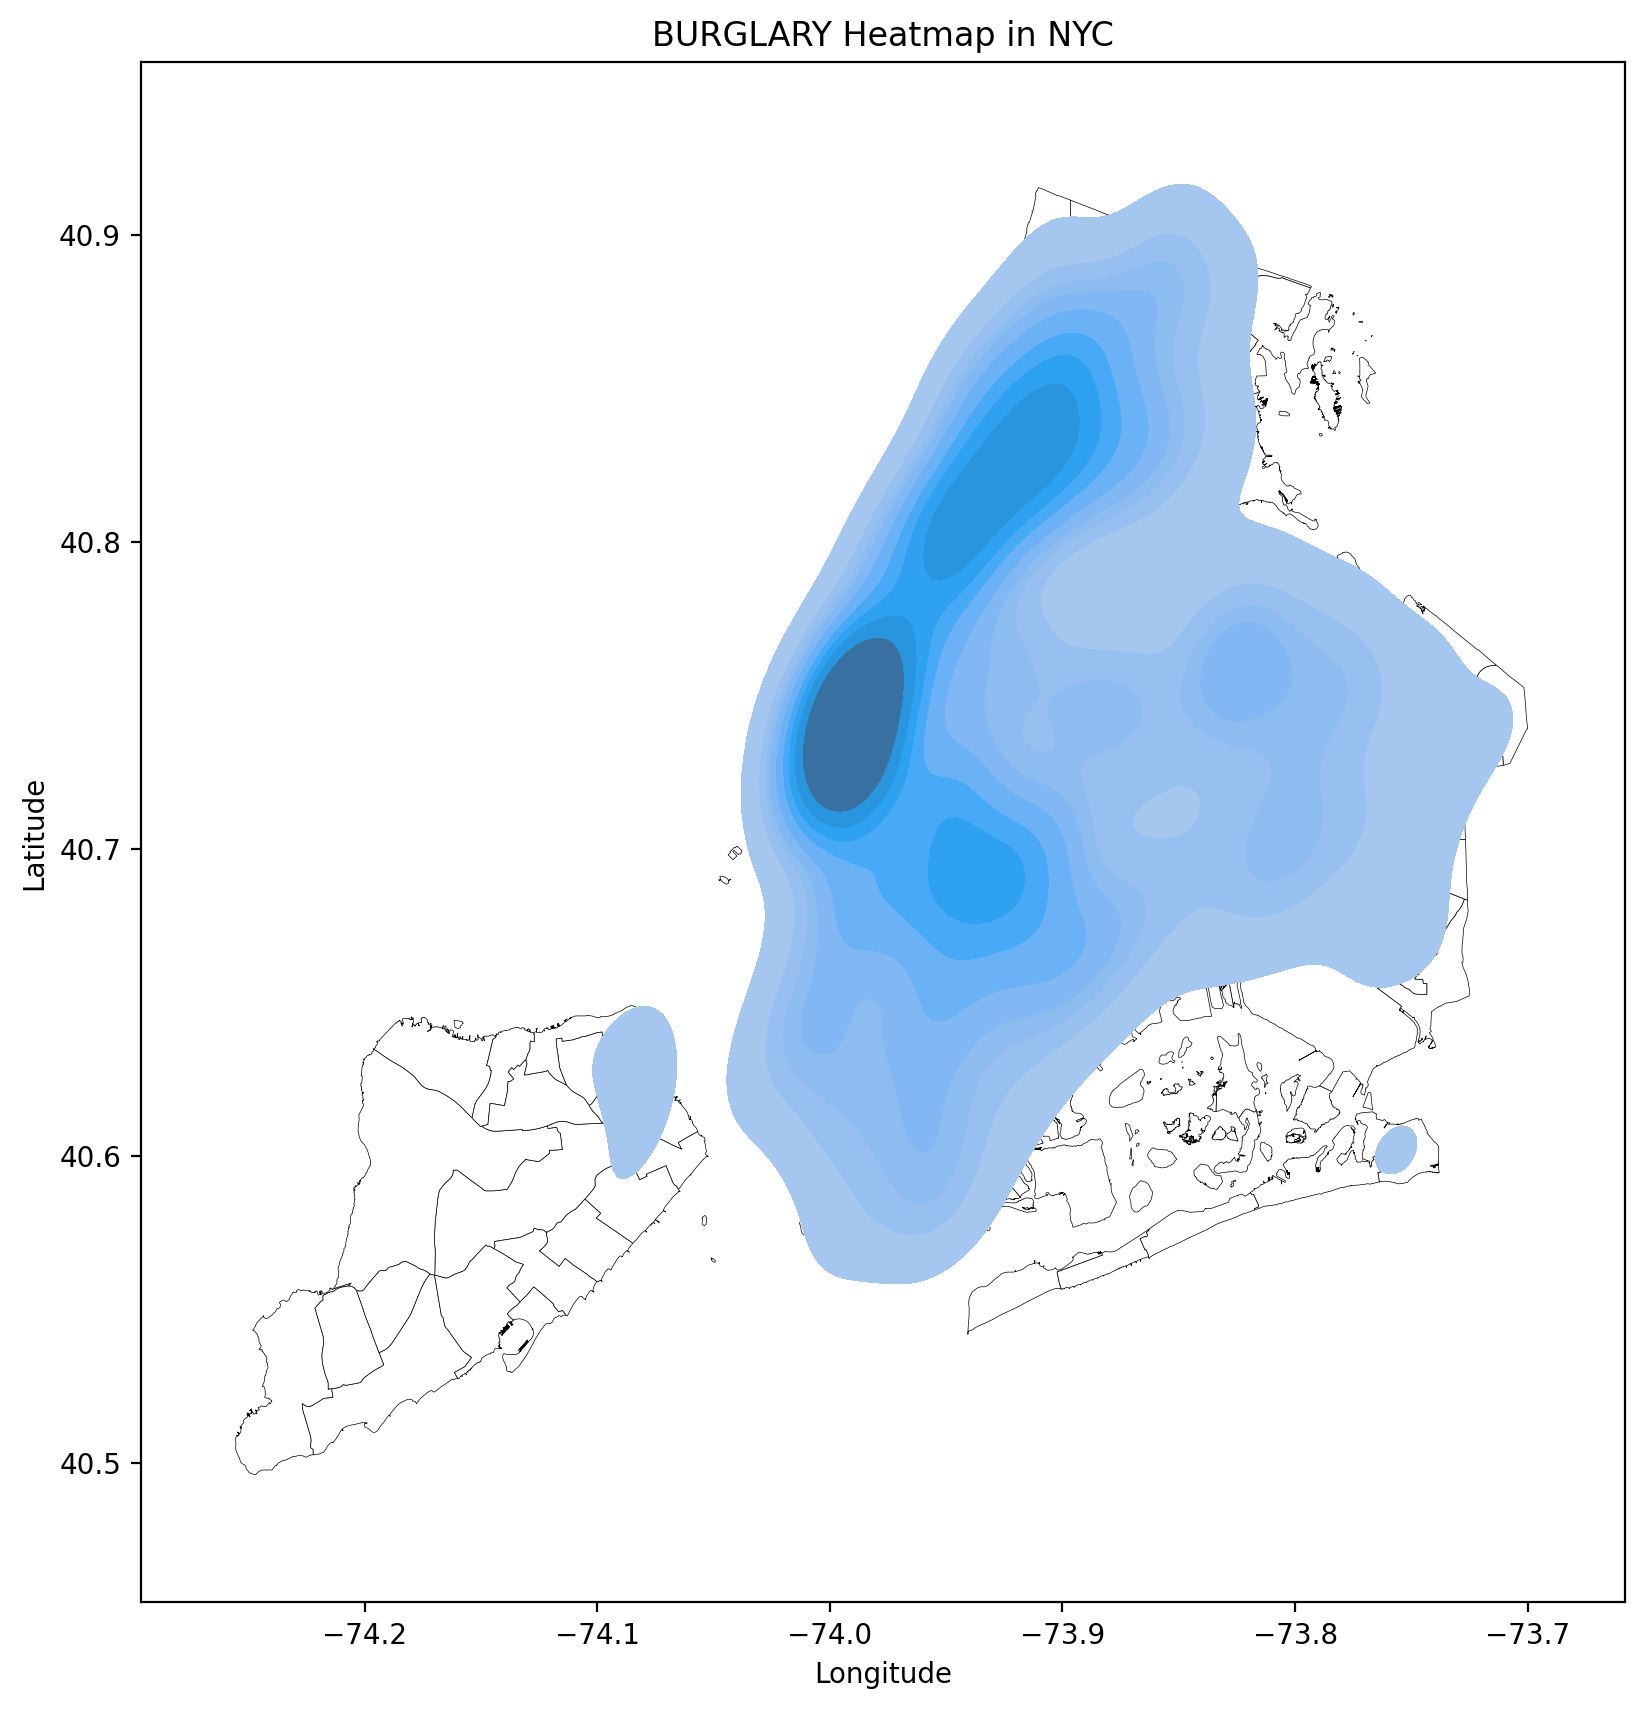

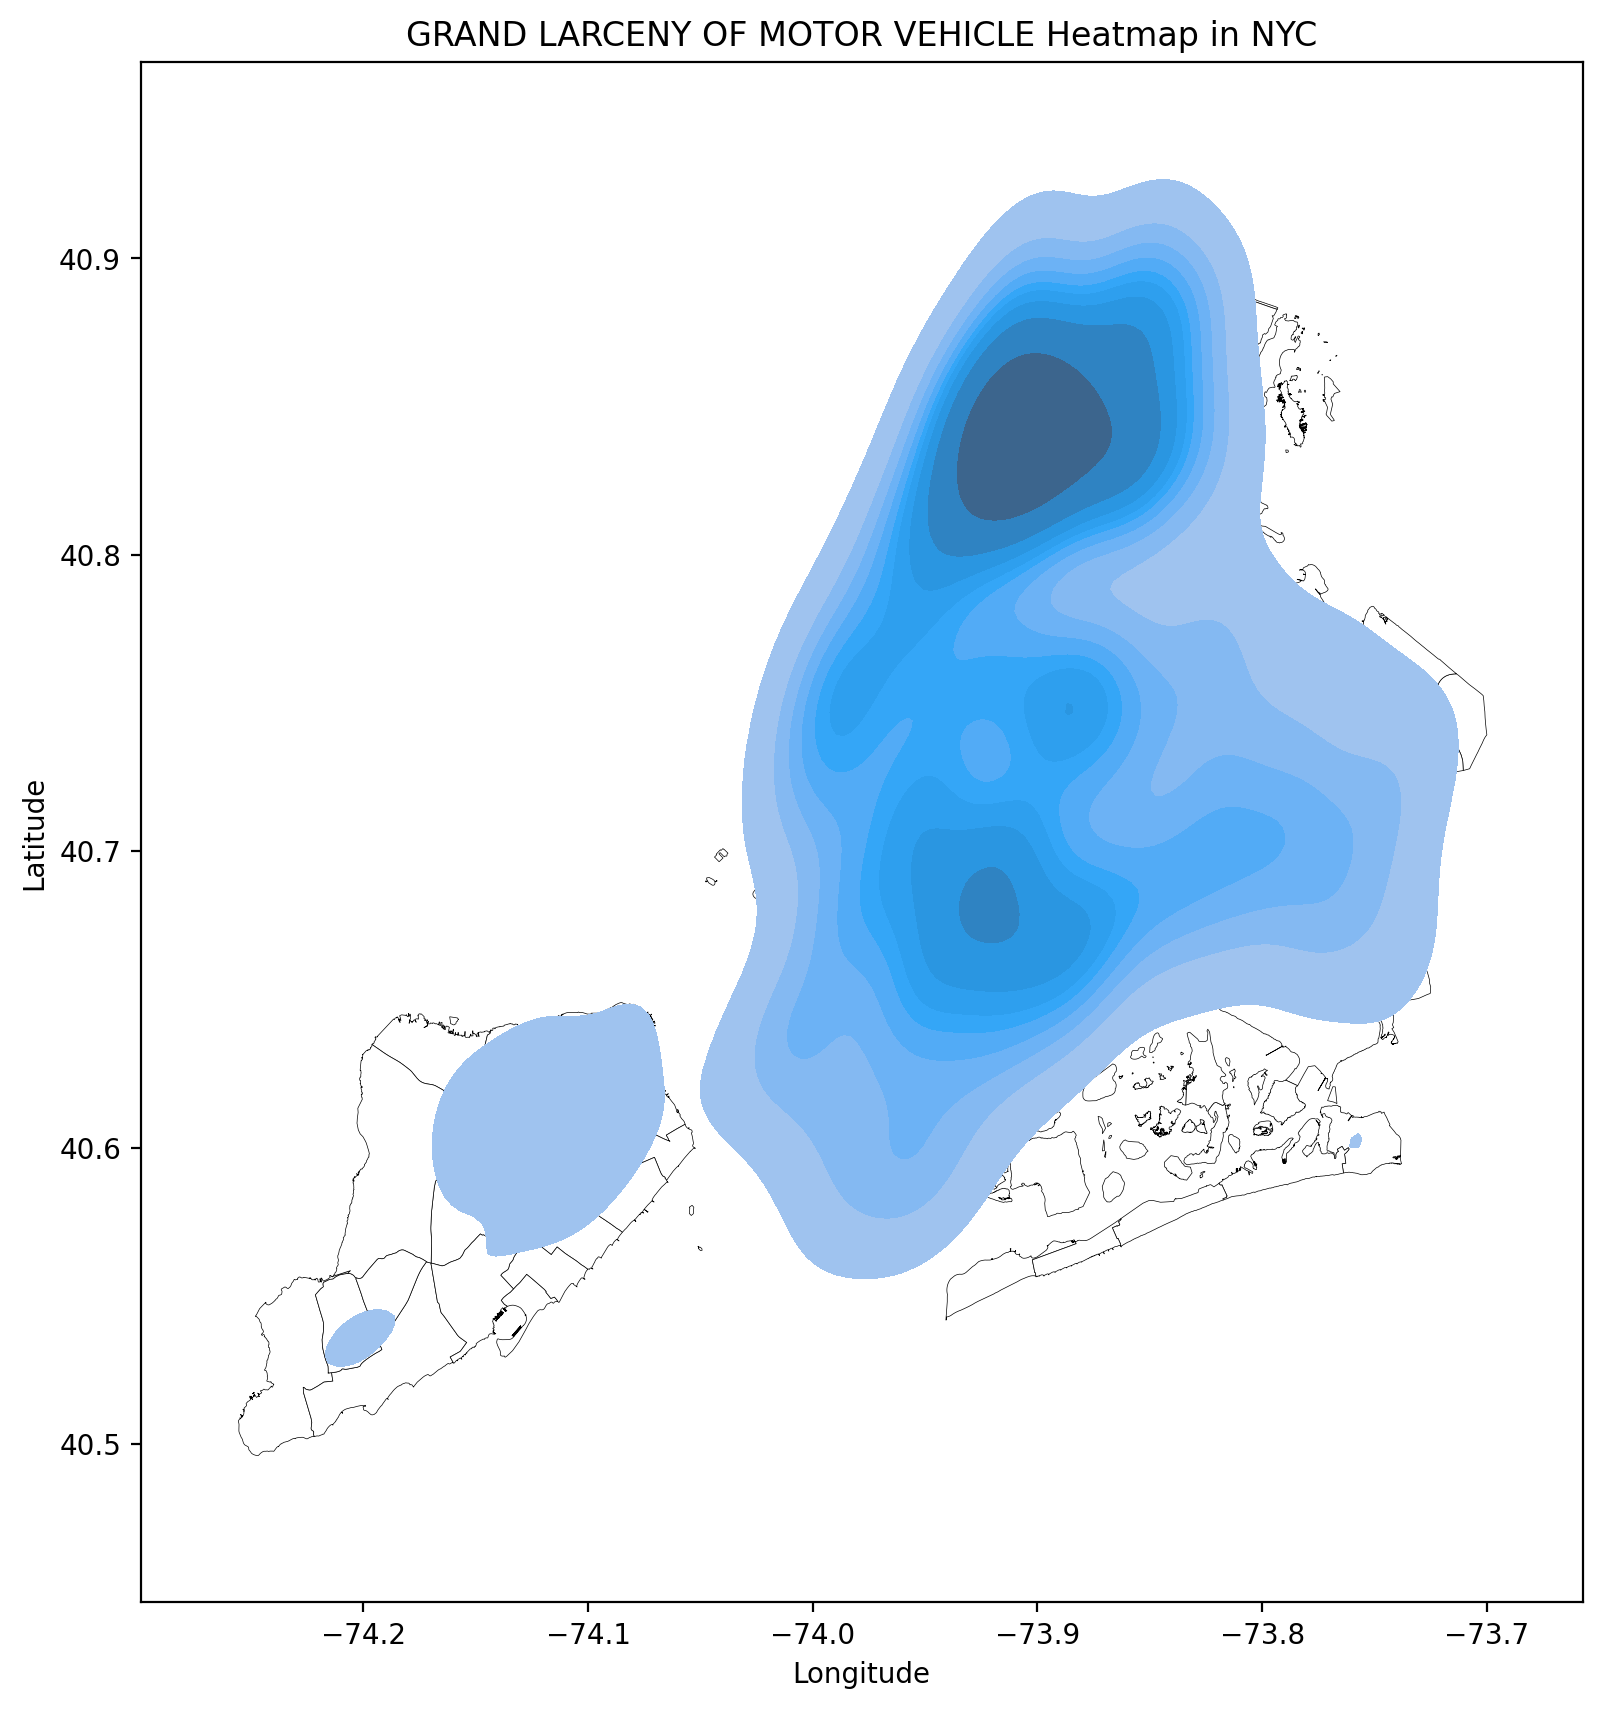

In [ ]:
import matplotlib.pyplot as plt

# Loading the shapefile for NYC
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')

# Filtering the data for felony types
felony_types = ['GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE']

# Loop through each felony type and create a separate map with heatmap
for felony in felony_types:
    # Creating a figure and axes for the map and heatmap
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the map of NYC
    df_nyc.plot(ax=ax, linewidth=0.25, color='White', edgecolor='Black')

    # Filtering the data for the current felony type
    df_felony = df[df['OFNS_DESC'] == felony]

    # Creating the heatmap using seaborn's kdeplot
    sns.kdeplot(x=df_felony['Longitude'], y=df_felony['Latitude'], fill=True, ax=ax)

    # Setting the title for the plot
    ax.set_title(felony + " Heatmap in NYC")

    # Displaying the plot
    plt.show()


